# GPU Exercise

In [2]:
from IPython.display import clear_output
from IPython.core.display import HTML
import numpy as np
from numba import jit, cuda, float32
# %matplotlib.inline
import matplotlib.pyplot as plt
import time

# clean up
clear_output()

## CPU (JIT)

In [7]:
@jit() # this decorator means we JIT compile this function, making it much faster
def jacobi_CPU(system_old, system_new):
    """
    Does one Jacobi iteration, sequantial and by CPU.
    Args:
        system_old: the system with its concentration values
        system_new: the system where the result will be stored
    """
    for row in range(1, system_old.shape[0]-1):     # do not update boundary
        for col in range(1, system_old.shape[1]-1): # do not update boundary
            system_new[row, col] = 0.25 * (system_old[row + 1, col] + system_old[row - 1, col] +
                                            system_old[row, col + 1] + system_old[row, col - 1])

C:\Users\mihbo\AppData\Local\Temp\ipykernel_22764\3766524345.py:1: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit() # this decorator means we JIT compile this function, making it much faster


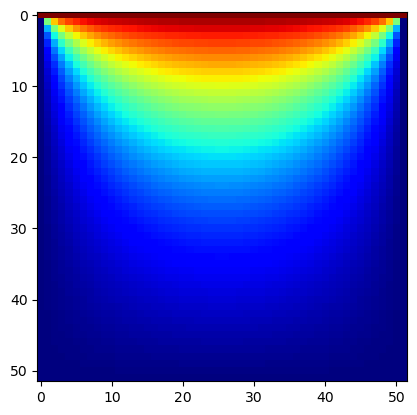

In [8]:
size = 50
system_a = np.zeros((size + 2, size + 2))
system_a[0] = 1
system_b = np.copy(system_a)

for _ in range(1000):
    jacobi_CPU(system_b, system_a)
    jacobi_CPU(system_a, system_b)

plt.imshow(system_b, cmap='jet')
plt.grid(False)
plt.show()

## GPU

In [9]:
@cuda.jit()
def jacobi_GPU(system_old, system_new):
    """
    Does one Jacobi iteration, parallel and by GPU.
    Args:
        system_old: the system with its concentration values
        system_new: the system where the result will be stored
    """
    row, col = cuda.grid(2) # get the position (row and column) on the grid
    row += 1; col += 1      # shift up one position, so we do not update the boundary conditions

    if 0 < row < system_old.shape[0] - 1 and 0 < col < system_old.shape[1] - 1:
        system_new[row, col] = 0.25 * (system_old[row + 1, col] + system_old[row - 1, col] + 
                                        system_old[row, col + 1] + system_old[row, col - 1])

Below is a helper function to set the correct grid size for the GPU function.

In [10]:
def invoke_smart_kernel(size, threads_per_block=(16,16)):
    blocks_per_grid = [(size + tpb - 1) // tpb for tpb in threads_per_block]
    return blocks_per_grid, threads_per_block

## Communicate between _host_ and _device_

In [11]:
size = 50

system_a = np.zeros((size + 2, size + 2))
system_a[0] = 1
system_b = np.copy(system_a)

d_system_a = cuda.to_device(system_a)
d_system_b = cuda.to_device(system_b)
for _ in range(1000):
    jacobi_GPU[invoke_smart_kernel(size)](d_system_b, d_system_a)
    jacobi_GPU[invoke_smart_kernel(size)](d_system_a, d_system_b)

system_b = d_system_b.copy_to_host()

plt.imshow(system_b, cmap='jet')
plt.grid(False)
plt.show()

TypeError: unhashable type: 'list'